In [1]:
import iris
import iris.analysis.stats as istats
import warnings
import matplotlib.pyplot as plt
import numpy as np
import iris.plot as iplt
import cartopy.crs as ccrs
import os
import datetime as dt
import cmocean

In [2]:
os.chdir("/home/548/eh6215/Desktop/python/BARPA_evaluation/emma/lib")
from load_cmip import load_cmip

In [36]:
alpha_w = iris.coords.AuxCoord(1/1000.,units='m**3*kg**-1')
cmip_info = {"ACCESS-CM2":("CSIRO-ARCCSS","r4i1p1f1"),"ACCESS-ESM1-5":('CSIRO','r6i1p1f1'),'NorESM2-MM':('NCC','r1i1p1f1')}
def load_cmip6(scenario,model,stream,var,t_s,t_e,Constraints,template=None,lapse=None,regrid_method=iris.analysis.Linear(),callback=None):
    group,rev  = cmip_info[model]
    if scenario == 'historical':
        mip = "CMIP"
    else:
        mip = "ScenarioMIP"
    path = "/g/data/r87/DRSv3/CMIP6/{mip}/{group}/{model}/{scenario}/{rev}/{stream}/{var}/gn/latest/".format(mip=mip,scenario=scenario,rev=rev,stream=stream,var=var,group=group,model=model)
    filepart = "{var}_{stream}_{model}_{scenario}_{rev}_gn".format(mip=mip,scenario=scenario,rev=rev,stream=stream,var=var,group=group,model=model)
    try:
        files = [f for f in os.listdir(path) if filepart in f]
    except:
        path = path.replace('latest','v20191108')
        files = [f for f in os.listdir(path) if filepart in f]
    starts = [f.split("_")[-1].split("-")[0] for f in files]
    ends = [f.split("_")[-1].split("-")[1] for f in files]
    starts = [dt.datetime(int(x[:4]),int(x[4:6]),1) for x in starts]
    ends = [dt.datetime(int(x[:4]),int(x[4:6]),1) for x in ends]
    files = [ os.path.join(path,f) for (i,f) in enumerate(files) if ((t_e  - starts[i]).days >0  and (ends[i] - t_s).days >= 0) ]
    ct = iris.Constraint(time = lambda t: ((dt.datetime(t.point.year,t.point.month,1) - t_s).days >= 0) and ((dt.datetime(t.point.year,t.point.month,1) - t_e).days < 0))
    data = iris.load(files,Constraints&ct)
    iris.util.equalise_attributes(data)
    data=data.concatenate_cube()
    if not template is None:
        data.coord('longitude').coord_system = template.coord('longitude').coord_system
        data.coord('latitude').coord_system = template.coord('latitude').coord_system
        data = data.regrid(template,regrid_method)
        if lapse is not None:
            topo_CMIP = iris.load_cube("/g/data/r87/DRSv3/CMIP6/{mip}/{group}/{model}/{scenario}/{rev}/fx/orog/gn/latest/orog_fx_{model}_{scenario}_{rev}_gn.nc".format(mip=mip,scenario=scenario,rev=rev,stream=stream,var=var,group=group,model=model),Constraints,callback)
            topo_CMIP.coord('longitude').coord_system = template.coord('longitude').coord_system
            topo_CMIP.coord('latitude').coord_system = template.coord('latitude').coord_system
            topo_CMIP = topo_CMIP.regrid(template,regrid_method)
            delta = (template - topo_CMIP)*lapse
            delta.convert_units(data.units)
            data.data = data.data + delta.data
    if var=='pr':
        name = data.name()
        data = data*alpha_w
        data.rename(name)
    return data

In [4]:
def callback(cube,field,filename):
    cube1 = cube.extract(iris.Constraint(longitude=lambda x: x>=0))
    cube2 = cube.extract(iris.Constraint(longitude=lambda x: x<0))
    cube2.coord('longitude').points = cube2.coord('longitude').points + 360
    if cube2.coord('longitude').has_bounds():
        cube2.coord('longitude').bounds = cube2.coord('longitude').bounds + 360
    return iris.cube.CubeList([cube1,cube2]).concatenate_cube()

In [5]:
prod = {"cg282_ACCESS-CM2_historical_1960_sciB":np.arange(1961,1966),
        "cg282_ACCESS-CM2_ssp126_2014_sciB":np.arange(2016,2020),
        "cg282_ACCESS-CM2_ssp370_2014_sciB":np.arange(2016,2020),
        "cg282_ERA5_historical_1979_sciB":np.arange(1980,1984),
        "cg282_ACCESS-ESM1-5_ssp370_2014_sciB":[2015,2016,2017],
        "cg282_NorESM2-MM_ssp370_2014_sciB":[2015]}


cx = iris.Constraint(longitude = lambda x: 90<=x<=200)
cy = iris.Constraint(latitude = lambda x: -50<=x<=10)

In [6]:
data = {}

for key in prod:
    data[key] = iris.load(["/g/data/tp28/dev/eh6215/comp/%s_sl_%d.nc"%(key,year) for year in prod[key]])
    for cube in data[key]:
        if cube.var_name != 'ttl_col_q':
            if cube.var_name[:9] == 'ttl_col_q':
                cube.var_name = 'ttl_col_q'
            else:
                cube.var_name=None
        cube.coord('time').var_name = None
        cube.coord('forecast_period').var_name = None
    iris.util.equalise_attributes(data[key])
    data[key] = data[key].merge().concatenate()
    for cube in data[key].extract("x_wind"):
        cube.rename('eastward_wind')
    for cube in data[key].extract("y_wind"):
        cube.rename('northward_wind')
    for cube in data[key].extract("air_temperature"):
        cube.rename('2 metre temperature')
    for cube in data[key].extract("ttl_col_q"):
        cube.units = "kg m**-2"
    for cube in data[key].extract("precipitation_flux"):
        cube.units = "mm/s"
        cube.convert_units('mm/day')
        cube.rename('precipitation')
    iris.util.equalise_attributes(data[key])
    data[key] = data[key].merge().concatenate()
    print(data[key])
    

0: ttl_col_q / (kg m**-2)              (time: 60; latitude: 458; longitude: 798)
1: 2 metre temperature / (K)           (time: 60; latitude: 458; longitude: 798)
2: air_pressure_at_sea_level / (Pa)    (time: 60; latitude: 458; longitude: 798)
3: air_temperature_max / (K)           (time: 60; latitude: 458; longitude: 798)
4: air_temperature_min / (K)           (time: 60; latitude: 458; longitude: 798)
5: eastward_wind / (m s-1)             (time: 60; pressure: 3; latitude: 459; longitude: 798)
6: northward_wind / (m s-1)            (time: 60; pressure: 3; latitude: 459; longitude: 798)
7: precipitation / (mm/day)            (time: 60; latitude: 458; longitude: 798)
8: specific_humidity / (1)             (time: 60; pressure: 3; latitude: 459; longitude: 798)
9: toa_outgoing_longwave_flux / (W m-2) (time: 60; latitude: 458; longitude: 798)
0: ttl_col_q / (kg m**-2)              (time: 48; latitude: 458; longitude: 798)
1: 2 metre temperature / (K)           (time: 48; latitude: 458; long

In [8]:
print(cmip6)

{'cg282_ACCESS-CM2_historical_1960_sciB': [<iris 'Cube' of ttl_col_q / (kg m-2) (time: 60; latitude: 50; longitude: 60)>,
<iris 'Cube' of 2 metre temperature / (K) (time: 60; latitude: 50; longitude: 60)>,
<iris 'Cube' of precipitation / (m.s-1) (time: 60; latitude: 50; longitude: 60)>,
<iris 'Cube' of air_pressure_at_sea_level / (Pa) (time: 60; latitude: 50; longitude: 60)>,
<iris 'Cube' of toa_outgoing_longwave_flux / (W m-2) (time: 60; latitude: 50; longitude: 60)>,
<iris 'Cube' of eastward_wind / (m s-1) (time: 60; air_pressure: 3; latitude: 49; longitude: 60)>,
<iris 'Cube' of northward_wind / (m s-1) (time: 60; air_pressure: 3; latitude: 49; longitude: 60)>,
<iris 'Cube' of specific_humidity / (1) (time: 60; air_pressure: 3; latitude: 50; longitude: 60)>], 'cg282_ACCESS-CM2_ssp126_2014_sciB': [<iris 'Cube' of ttl_col_q / (kg m-2) (time: 48; latitude: 50; longitude: 60)>,
<iris 'Cube' of 2 metre temperature / (K) (time: 48; latitude: 50; longitude: 60)>,
<iris 'Cube' of precipitat

In [9]:
varlist = {'ttl_col_q':('prw',2),
        '2 metre temperature':('tas',2),
        'precipitation':('pr',2),
        'air_pressure_at_sea_level':('psl',2),
        'toa_outgoing_longwave_flux':('rlut',2),
        'eastward_wind':('ua',3),
        'northward_wind':('va',3),
        'specific_humidity':('hus',3)}

cp =iris.Constraint(air_pressure = lambda p: p in [20000,50000,85000])
cmip6 = {}
for key in prod:
    if 'ERA5' not in key and key not in cmip6.keys():
        print(key)
        cmip6[key]=iris.cube.CubeList()
        year0 =prod[key][0]
        year1 =prod[key][-1]+1
        model,scen = key.split("_")[1:3]
        for var in varlist:
            try:
                if varlist[var][1]==2:
                    cmip6[key].append(load_cmip6(scen,model,"Amon",varlist[var][0],dt.datetime(year0,1,1),dt.datetime(year1,1,1),cx&cy,callback=callback))
                if varlist[var][1]==3:
                    cmip6[key].append(load_cmip6(scen,model,"Amon",varlist[var][0],dt.datetime(year0,1,1),dt.datetime(year1,1,1),cx&cy&cp,callback=callback))
                cmip6[key][-1].rename(var)
                if var == 'precipitation':
                    cmip6[key][-1].convert_units("mm/day")
            except FileNotFoundError:
                print(varlist[var])
    


cg282_ACCESS-CM2_historical_1960_sciB


/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/iris/fileformats/cf.py:859: UserWarning: Missing CF-netCDF measure variable 'areacella', referenced by netCDF variable 'prw'
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/iris/fileformats/cf.py:859: UserWarning: Missing CF-netCDF measure variable 'areacella', referenced by netCDF variable 'tas'
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/iris/fileformats/cf.py:859: UserWarning: Missing CF-netCDF measure variable 'areacella', referenced by netCDF variable 'pr'
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/iris/fileformats/cf.py:859: UserWarning: Missing CF-netCDF measure variable 'areacella', referenced by netCDF variable 'psl'
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/iris/fileform

cg282_ACCESS-CM2_ssp126_2014_sciB


/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/iris/fileformats/cf.py:859: UserWarning: Missing CF-netCDF measure variable 'areacella', referenced by netCDF variable 'prw'
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/iris/fileformats/cf.py:859: UserWarning: Missing CF-netCDF measure variable 'areacella', referenced by netCDF variable 'tas'
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/iris/fileformats/cf.py:859: UserWarning: Missing CF-netCDF measure variable 'areacella', referenced by netCDF variable 'pr'
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/iris/fileformats/cf.py:859: UserWarning: Missing CF-netCDF measure variable 'areacella', referenced by netCDF variable 'psl'
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/iris/fileform

cg282_ACCESS-CM2_ssp370_2014_sciB


/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/iris/fileformats/cf.py:859: UserWarning: Missing CF-netCDF measure variable 'areacella', referenced by netCDF variable 'prw'
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/iris/fileformats/cf.py:859: UserWarning: Missing CF-netCDF measure variable 'areacella', referenced by netCDF variable 'tas'
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/iris/fileformats/cf.py:859: UserWarning: Missing CF-netCDF measure variable 'areacella', referenced by netCDF variable 'pr'
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/iris/fileformats/cf.py:859: UserWarning: Missing CF-netCDF measure variable 'areacella', referenced by netCDF variable 'psl'
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/iris/fileform

cg282_ACCESS-ESM1-5_ssp370_2014_sciB


/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/iris/fileformats/cf.py:859: UserWarning: Missing CF-netCDF measure variable 'areacella', referenced by netCDF variable 'prw'
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/iris/fileformats/cf.py:859: UserWarning: Missing CF-netCDF measure variable 'areacella', referenced by netCDF variable 'tas'
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/iris/fileformats/cf.py:859: UserWarning: Missing CF-netCDF measure variable 'areacella', referenced by netCDF variable 'pr'
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/iris/fileformats/cf.py:859: UserWarning: Missing CF-netCDF measure variable 'areacella', referenced by netCDF variable 'psl'
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/iris/fileform

cg282_NorESM2-MM_ssp370_2014_sciB
('prw', 2)


/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/iris/fileformats/cf.py:859: UserWarning: Missing CF-netCDF measure variable 'areacella', referenced by netCDF variable 'tas'
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/iris/fileformats/cf.py:859: UserWarning: Missing CF-netCDF measure variable 'areacella', referenced by netCDF variable 'pr'
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/iris/fileformats/cf.py:859: UserWarning: Missing CF-netCDF measure variable 'areacella', referenced by netCDF variable 'psl'
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/iris/fileformats/cf.py:859: UserWarning: Missing CF-netCDF measure variable 'areacella', referenced by netCDF variable 'rlut'
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/iris/filefor

('hus', 3)


In [10]:
ref = iris.load("/g/data/tp28/dev/eh6215/comp/era5.nc")
ref.extract("air_pressure_at_mean_sea_level")[0].rename("air_pressure_at_sea_level")
ref.extract("Mean top net long-wave radiation flux")[0].data = ref.extract("Mean top net long-wave radiation flux")[0].data*-1
ref.extract("Mean top net long-wave radiation flux")[0].rename("toa_outgoing_longwave_flux")
ref.extract("lwe_thickness_of_atmosphere_mass_content_of_water_vapor")[0].rename("ttl_col_q")
iris.util.equalise_attributes(ref)
print(ref)
print(data["cg282_ACCESS-CM2_ssp126_2014_sciB"])

0: toa_outgoing_longwave_flux / (W m**-2) (time: 12; latitude: 241; longitude: 441)
1: 2 metre temperature / (K)           (time: 12; latitude: 241; longitude: 441)
2: air_pressure_at_sea_level / (Pa)    (time: 12; latitude: 241; longitude: 441)
3: air_temperature / (K)               (time: 12; pressure_level: 3; latitude: 241; longitude: 441)
4: eastward_wind / (m s**-1)           (time: 12; pressure_level: 3; latitude: 241; longitude: 441)
5: ttl_col_q / (kg m**-2)              (time: 12; latitude: 241; longitude: 441)
6: northward_wind / (m s**-1)          (time: 12; pressure_level: 3; latitude: 241; longitude: 441)
7: specific_humidity / (kg kg**-1)     (time: 12; pressure_level: 3; latitude: 241; longitude: 441)
0: ttl_col_q / (kg m**-2)              (time: 48; latitude: 458; longitude: 798)
1: 2 metre temperature / (K)           (time: 48; latitude: 458; longitude: 798)
2: air_pressure_at_sea_level / (Pa)    (time: 48; latitude: 458; longitude: 798)
3: air_temperature_max / (K)  

In [14]:
precip = iris.load_cube("/g/data/tp28/dev/eh6215/comp/gpcp.nc",'precip').extract(cx&cy)
precip.coord('time').points = [18993.-365, 19024.-365, 18687., 18718., 18748., 18779., 18809., 18840., 18871., 18901., 18932., 18962.]
precip.coord('time').bounds=None
iris.util.promote_aux_coord_to_dim_coord(precip,'time')
precip.rename('precipitation')
print(precip.summary(shorten=True))
ref.append(precip)

precipitation / (mm/day)            (time: 12; latitude: 26; longitude: 46)


/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/iris/fileformats/_nc_load_rules/helpers.py:874: UserWarning: Failed to create 'time' dimension coordinate: The 'time' DimCoord points array must be strictly monotonic.
Gracefully creating 'time' auxiliary coordinate instead.
  warnings.warn(msg.format(name=str(cf_coord_var.cf_name), error=e_msg))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/iris/fileformats/_nc_load_rules/helpers.py:874: UserWarning: Failed to create 'time' dimension coordinate: The 'time' DimCoord points array must be strictly monotonic.
Gracefully creating 'time' auxiliary coordinate instead.
  warnings.warn(msg.format(name=str(cf_coord_var.cf_name), error=e_msg))


AMIP validation variables are: 

PMSL global 

Precip land - bands (DJF, MAM, JJA, SON) 

Precip ocean - bands (DJF, MAM, JJA, SON) 

Precipitable water (DJF,JJA) 

1.5m mean temperature (DJF,JJA) 

200 hPa horizontal wind (DJF, JJA) 

850 hPa horizontal wind (DJF, JJA) 

zonal mean U wind (DJF, JJA) 

zonal mean V wind (DJF, JJA) 


In [113]:
vars = ['air_pressure_at_sea_level', '2 metre temperature', 'toa_outgoing_longwave_flux', 'eastward_wind', 'northward_wind', 'specific_humidity', 'ttl_col_q']

corrs = {}
bias  = {}
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for var in vars:
        print(var)
        r = ref.extract_cube(var)[:12].collapsed('time',iris.analysis.MEAN)
        if r.ndim==2:
            corrs[var],bias[var] = {},{}
        else:
            for p in ['200','500','850']:
                corrs[var+p],bias[var+p] = {},{}
        for key in prod:
            d = data[key].extract_cube(var).collapsed('time',iris.analysis.MEAN)
            r=r.regrid(d,iris.analysis.Linear())
            if r.ndim == 2:
                corrs[var][key] = iris.analysis.stats.pearsonr(r,d,['longitude','latitude']).data
                bias[var][key] = ((r - d).collapsed(['longitude','latitude'],iris.analysis.MEAN)/r.collapsed(['longitude','latitude'],iris.analysis.STD_DEV)).data
            else:
                for p in [200,500,850]:
                    rr = r.extract(iris.Constraint(pressure_level = p) )#.collapsed('time',iris.analysis.MEAN)
                    dd = d.extract(iris.Constraint(pressure = p) )#.collapsed('time',iris.analysis.MEAN)
                    corrs["%s%d"%(var,p)][key] = iris.analysis.stats.pearsonr(rr,dd,['longitude','latitude']).data
                    bias["%s%d"%(var,p)][key] = ((rr - dd).collapsed(['longitude','latitude'],iris.analysis.MEAN)/rr.collapsed(['longitude','latitude'],iris.analysis.STD_DEV)).data

air_pressure_at_sea_level
2 metre temperature
toa_outgoing_longwave_flux
eastward_wind
northward_wind
specific_humidity
ttl_col_q


In [104]:
vars = ['air_pressure_at_sea_level', '2 metre temperature', 'toa_outgoing_longwave_flux', 'eastward_wind', 'northward_wind', 'specific_humidity', 'ttl_col_q']
print('h')
corrs_cmip = {}
bias_cmip  = {}
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for var in vars:
        print(var)
        r = ref.extract_cube(var)[:12].collapsed('time',iris.analysis.MEAN)
        if r.ndim==2:
            corrs_cmip[var],bias_cmip[var] = {},{}
        else:
            for p in ['200','500','850']:
                corrs_cmip[var+p],bias_cmip[var+p] = {},{}
        for key in prod:
            if 'ERA5' not in key:
                try:
                    d = cmip6[key].extract_cube(var).collapsed('time',iris.analysis.MEAN)
                    r=r.regrid(d,iris.analysis.Linear())
                    if r.ndim == 2:
                        corrs_cmip[var][key] = iris.analysis.stats.pearsonr(r,d,['longitude','latitude']).data
                        bias_cmip[var][key] = ((r - d).collapsed(['longitude','latitude'],iris.analysis.MEAN)/r.collapsed(['longitude','latitude'],iris.analysis.STD_DEV)).data
                    else:
                        for p in [200,500,850]:
                            rr = r.extract(iris.Constraint(pressure_level = p) )#.collapsed('time',iris.analysis.MEAN)
                            dd = d.extract(iris.Constraint(air_pressure = p*100) )#.collapsed('time',iris.analysis.MEAN)
                            corrs_cmip["%s%d"%(var,p)][key] = iris.analysis.stats.pearsonr(rr,dd,['longitude','latitude']).data
                            bias_cmip["%s%d"%(var,p)][key] = ((rr - dd).collapsed(['longitude','latitude'],iris.analysis.MEAN)/rr.collapsed(['longitude','latitude'],iris.analysis.STD_DEV)).data
                except:
                    continue

h
air_pressure_at_sea_level
2 metre temperature
toa_outgoing_longwave_flux
eastward_wind
northward_wind
specific_humidity
ttl_col_q


In [136]:
print(bias)


{'air_pressure_at_sea_level': {'cg282_ACCESS-CM2_historical_1960_sciB': array(0.14013486), 'cg282_ACCESS-CM2_ssp126_2014_sciB': array(-0.00584763), 'cg282_ACCESS-CM2_ssp370_2014_sciB': array(0.07239914), 'cg282_ERA5_historical_1979_sciB': array(0.08795635)}, '2 metre temperature': {'cg282_ACCESS-CM2_historical_1960_sciB': array(-0.05880315), 'cg282_ACCESS-CM2_ssp126_2014_sciB': array(-0.15209166), 'cg282_ACCESS-CM2_ssp370_2014_sciB': array(-0.1373221), 'cg282_ERA5_historical_1979_sciB': array(-0.00900691)}, 'toa_outgoing_longwave_flux': {'cg282_ACCESS-CM2_historical_1960_sciB': array(0.2303065), 'cg282_ACCESS-CM2_ssp126_2014_sciB': array(0.19185334), 'cg282_ACCESS-CM2_ssp370_2014_sciB': array(0.18016832), 'cg282_ERA5_historical_1979_sciB': array(0.13563256)}, 'eastward_wind200': {'cg282_ACCESS-CM2_historical_1960_sciB': array(-0.09276623), 'cg282_ACCESS-CM2_ssp126_2014_sciB': array(-0.11379208), 'cg282_ACCESS-CM2_ssp370_2014_sciB': array(-0.10386606), 'cg282_ERA5_historical_1979_sciB':

Text(0.5, 1.0, 'barpa correlation')

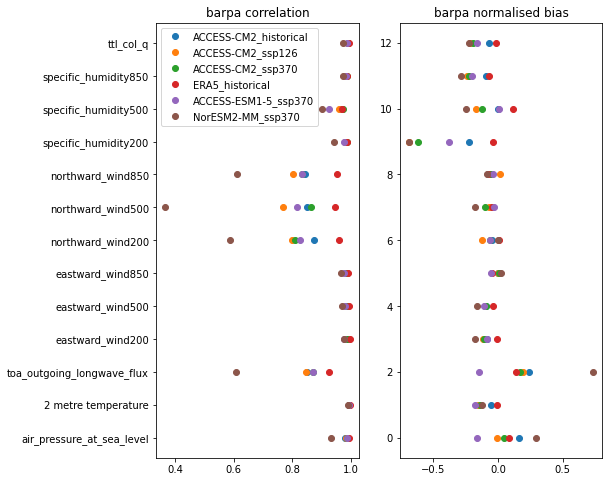

In [117]:
plt.figure(figsize=(8,8))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

ax1.set_title('barpa correlation')
ax2.set_title('barpa normalised bias')

c = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown']
for j,var in enumerate(list(corrs.keys())):
    for i,key in enumerate(prod):
        if j==0:
            ax1.plot([corrs[var][key]],[j],'o',c=c[i],label=key[6:-10])
        else:
            ax1.plot([corrs[var][key]],[j],'o',c=c[i])
        ax2.plot([bias[var][key]],[j],'o',c=c[i])

ax1.legend()
ax1.set_yticks(np.arange(0,len(corrs)))
ax1.set_yticklabels(list(corrs.keys()))
ax1.title

Text(0.5, 1.0, 'cmip6 correlation')

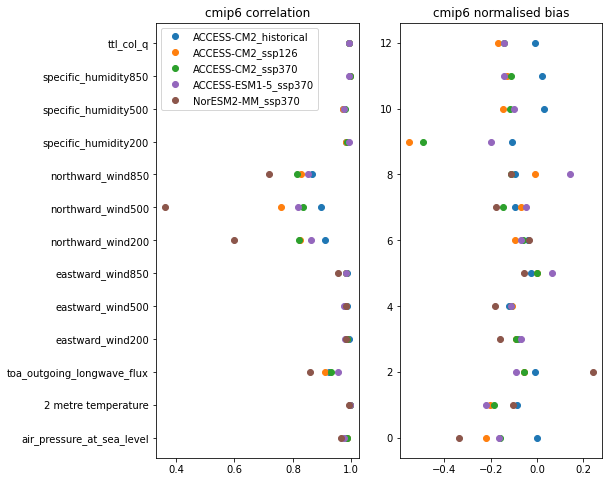

In [118]:
plt.figure(figsize=(8,8))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
ax1.set_title('cmip6 correlation')
ax2.set_title('cmip6 normalised bias')
c = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown']
for j,var in enumerate(list(corrs_cmip.keys())):
    for i,key in enumerate(prod):
        if 'ERA5' not in key:
            if j==0:
                ax1.plot([corrs_cmip[var][key]],[j],'o',c=c[i],label=key[6:-10])
            else:
                try:
                    ax1.plot([corrs_cmip[var][key]],[j],'o',c=c[i])
                except KeyError:
                    continue
            ax2.plot([bias_cmip[var][key]],[j],'o',c=c[i])

ax1.legend()
ax1.set_yticks(np.arange(0,len(corrs_cmip)))
ax1.set_yticklabels(list(corrs_cmip.keys()))
ax1.title

In [30]:
plot_properties = {'toa_outgoing_longwave_flux':(150,300,100,'binary','bwr'),
                  '2 metre temperature':(280,307,3,'hot_r','bwr'),
                  'eastward_wind850':(-30,30,5,'PiYG','PiYG'),
                  'northward_wind850':(-8,8,4,'PiYG','PiYG'),
                   'ttl_col_q':(0,60,20,cmocean.cm.rain,'BrBG'),
                   'air_pressure_at_sea_level':(99000,103000,1000,'viridis','BrBG'),
                   'precipitation':(0,30,10,cmocean.cm.rain,'BrBG')
                  }

toa_outgoing_longwave_flux
2 metre temperature
precipitation


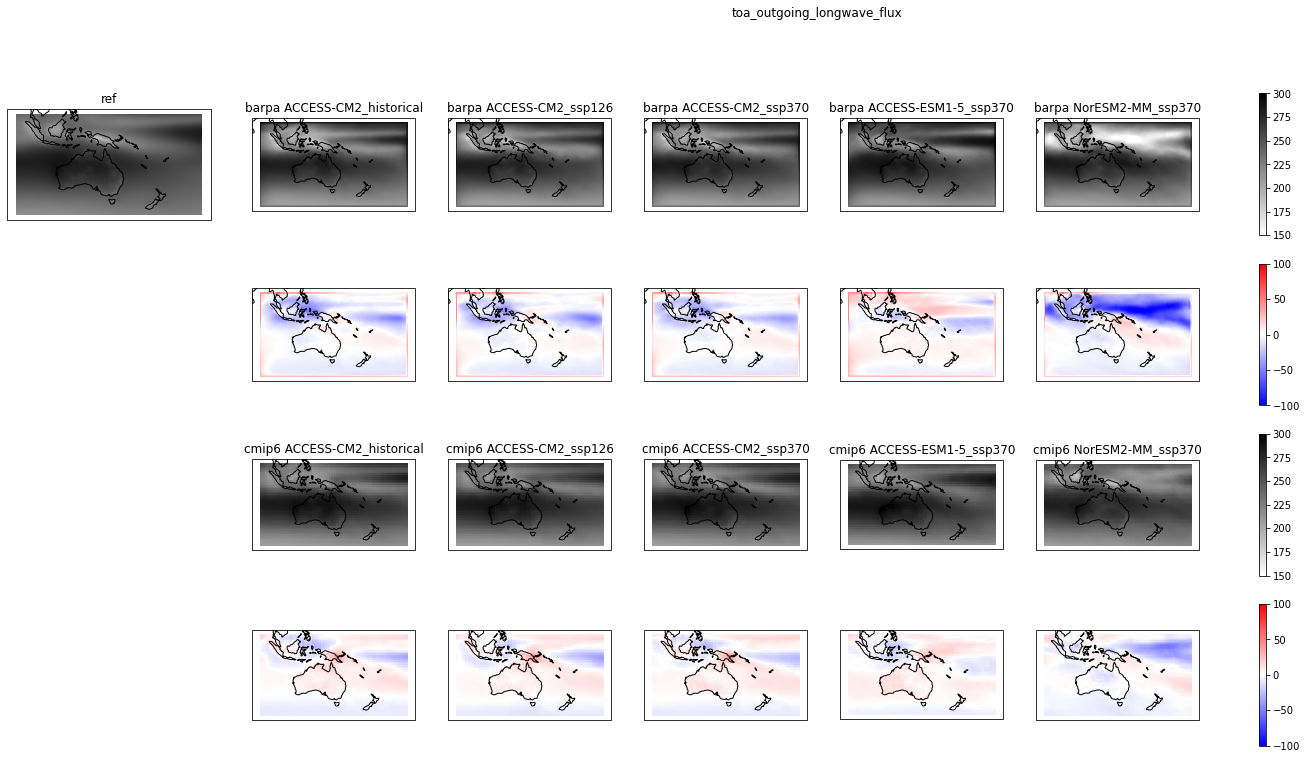

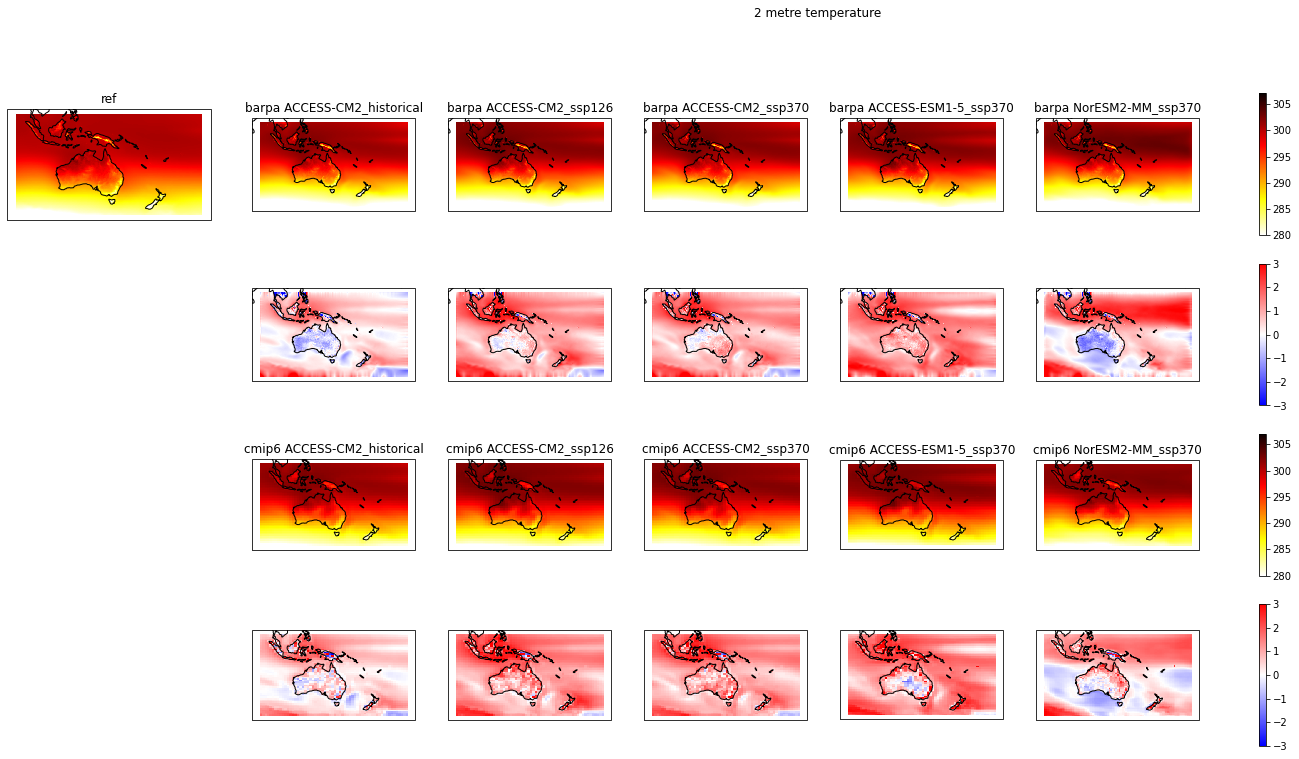

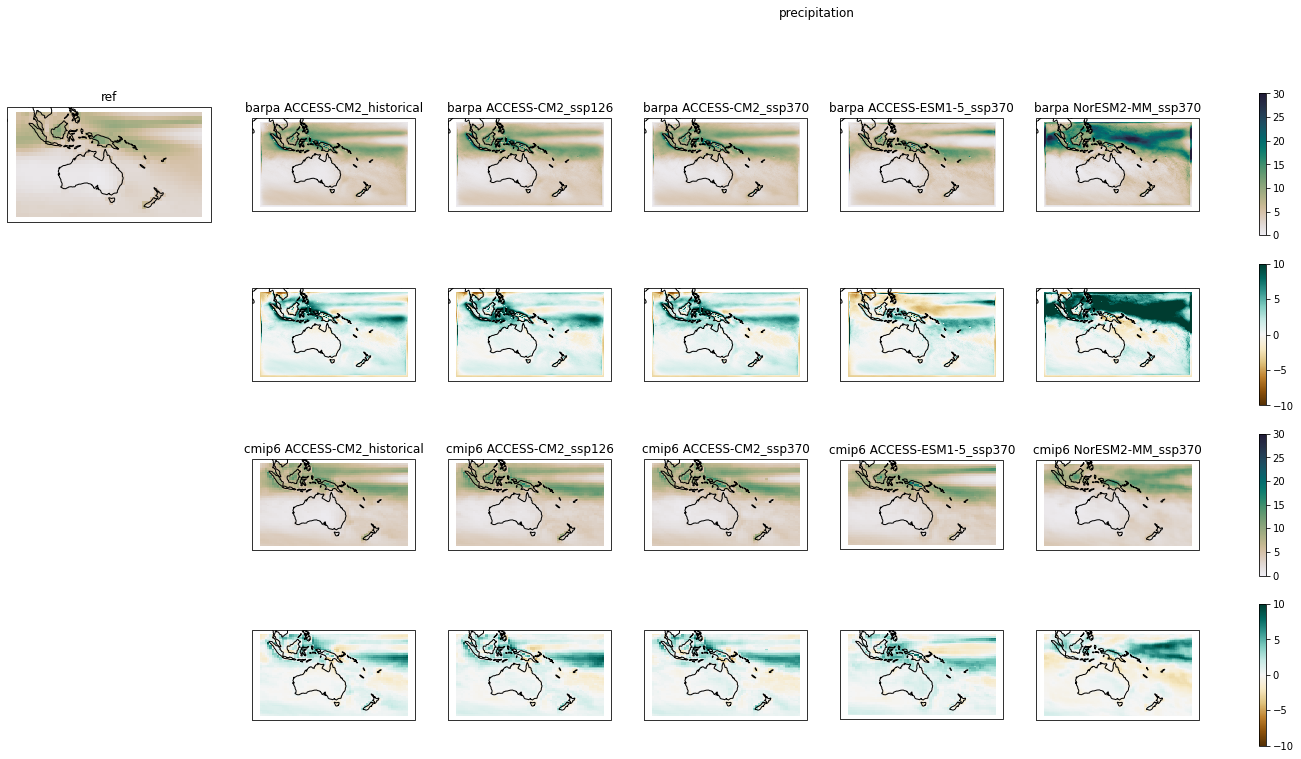

In [67]:

for var,p in [('toa_outgoing_longwave_flux',""),('2 metre temperature',""),('precipitation',"")]:
    vmin,vmax,vdiff,cmap1,cmap2=plot_properties[var+p]
    n = len(prod)
    fig=plt.figure(figsize=(30,12))
    plt.suptitle(var)
    axs1,axs2,axs3,axs4=[],[],[],[]
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        print(var)
        r = ref.extract_cube(var).collapsed('time',iris.analysis.MEAN)
        ax=plt.subplot(4,n+1,1,projection=ccrs.PlateCarree(180))
        if r.ndim==3:
            r = r.extract(iris.Constraint(pressure_level = int(p)) )#.collapsed('time',iris.analysis.MEAN)            
        iplt.pcolormesh(r,vmin=vmin,vmax=vmax,cmap=cmap1)
        plt.title("ref")
        ax.coastlines()
        for i,key in enumerate([key for key in prod if 'ERA5' not in key]):
            d = data[key].extract_cube(var)[:].collapsed('time',iris.analysis.MEAN)
            c = cmip6[key].extract_cube(var)[:].collapsed('time',iris.analysis.MEAN)
            rc=r.regrid(c,iris.analysis.Linear())
            r=r.regrid(d,iris.analysis.Linear())
            if d.ndim == 3:
                d = d.extract(iris.Constraint(pressure = int(p)) )
                c = c.extract(iris.Constraint(air_pressure = int(p)*100) )
            axs1.append(plt.subplot(4,n+1,i+2,projection=ccrs.PlateCarree(180)))
            a1=iplt.pcolormesh(d,vmin=vmin,vmax=vmax,cmap=cmap1)
            plt.title('barpa '+key[6:-10])
            axs1[-1].coastlines()
            axs2.append(plt.subplot(4,n+1,i+2+1*(n+1),projection=ccrs.PlateCarree(180)))
            a2=iplt.pcolormesh(d-r,vmin=-vdiff,vmax=vdiff,cmap=cmap2)
            axs2[-1].coastlines()
            axs3.append(plt.subplot(4,n+1,i+2+2*(n+1),projection=ccrs.PlateCarree(180)))
            a3=iplt.pcolormesh(c,vmin=vmin,vmax=vmax,cmap=cmap1)
            axs3[-1].coastlines()
            plt.title('cmip6 '+key[6:-10])
            axs4.append(plt.subplot(4,n+1,i+2+3*(n+1),projection=ccrs.PlateCarree(180)))
            a4=iplt.pcolormesh(c-rc,vmin=-vdiff,vmax=vdiff,cmap=cmap2)
            axs4[-1].coastlines()
    fig.colorbar(a1,ax=axs1)
    fig.colorbar(a2,ax=axs2)
    fig.colorbar(a3,ax=axs3)
    fig.colorbar(a4,ax=axs4)

In [80]:
print(cmip6['cg282_ACCESS-CM2_historical_1960_sciB'].extract('eastward_wind')[0].coord('air_pressure'))

DimCoord(array([1000.,  500.,  100.]), bounds=array([[1500.,  750.],
       [ 750.,  300.],
       [ 300., -100.]]), standard_name='air_pressure', units=Unit('Pa'), long_name='pressure', var_name='plev', attributes={'positive': 'down'})


In [103]:
1

1

In [40]:
cx2=iris.Constraint(longitude=lambda x:160<=x<=200)
cy2=iris.Constraint(latitude=lambda y:-15<=y<=15)



/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/iris/fileformats/cf.py:859: UserWarning: Missing CF-netCDF measure variable 'areacella', referenced by netCDF variable 'ts'
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/iris/fileformats/cf.py:859: UserWarning: Missing CF-netCDF measure variable 'areacella', referenced by netCDF variable 'ts'
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/iris/fileformats/cf.py:859: UserWarning: Missing CF-netCDF measure variable 'areacella', referenced by netCDF variable 'ts'
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/iris/fileformats/cf.py:859: UserWarning: Missing CF-netCDF measure variable 'areacella', referenced by netCDF variable 'ts'
  warnings.warn(


cg282_NorESM2-MM_ssp370_2014_sciB


/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/iris/fileformats/cf.py:859: UserWarning: Missing CF-netCDF measure variable 'areacella', referenced by netCDF variable 'ts'
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/iris/fileformats/cf.py:859: UserWarning: Missing CF-netCDF measure variable 'areacella', referenced by netCDF variable 'ts'
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/iris/fileformats/cf.py:859: UserWarning: Missing CF-netCDF measure variable 'areacella', referenced by netCDF variable 'ts'
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/iris/cube.py:3523: UserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(msg.format(coord.name()))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/iris/fileformats/cf.py:8

cg282_NorESM2-MM_ssp370_2014_sciB


/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/iris/fileformats/cf.py:859: UserWarning: Missing CF-netCDF measure variable 'areacella', referenced by netCDF variable 'ts'
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/iris/cube.py:3523: UserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(msg.format(coord.name()))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/iris/fileformats/cf.py:859: UserWarning: Missing CF-netCDF measure variable 'areacella', referenced by netCDF variable 'ts'
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/iris/cube.py:3523: UserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(msg.format(coord.name()))


cg282_NorESM2-MM_ssp370_2014_sciB


/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/iris/fileformats/cf.py:859: UserWarning: Missing CF-netCDF measure variable 'areacella', referenced by netCDF variable 'ts'
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/iris/cube.py:3523: UserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(msg.format(coord.name()))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/iris/fileformats/cf.py:859: UserWarning: Missing CF-netCDF measure variable 'areacella', referenced by netCDF variable 'ts'
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/iris/cube.py:3523: UserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(msg.format(coord.name()))


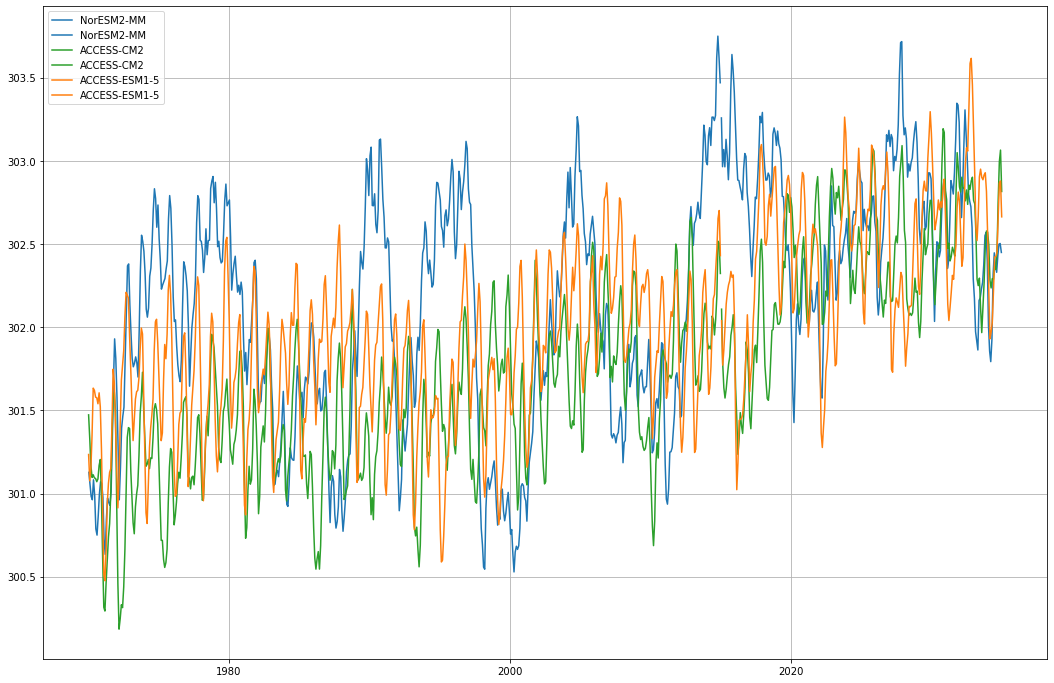

In [64]:
from iris.coord_categorisation  import add_year
c = ['tab:blue','tab:green','tab:orange']
plt.figure(figsize=(18,12))
for i,model in enumerate(["NorESM2-MM","ACCESS-CM2","ACCESS-ESM1-5"]):
    if 'ERA5' not in key:# and key not in cmip6.keys():
        print(key)
        for scen in ['ssp370','historical']:
            Tn = load_cmip6(scen,model,"Amon","ts",dt.datetime(1970,1,1),dt.datetime(2035,1,1),cx2&cy2,callback=callback)
            #add_year(Tn,'time','year')
            #Tn= Tn.aggregated_by('year',iris.analysis.MEAN)
            iplt.plot(Tn.collapsed(['latitude','longitude'],iris.analysis.MEAN),label=model,c=c[i])

plt.grid()
plt.legend()